In [1]:
# %% Import Packages
import tensorflow as tf
print(tf.__version__)

from keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

2.9.3


In [2]:
img_list = glob('C:\\Users\\LEE CHANG YOUNG\\Documents\\GitHub\\alibi-detect_test\\good_screw\\*.png')

In [3]:

len(img_list)

320

In [4]:

train_img_list, val_img_list = train_test_split(img_list, test_size=0.2, random_state=2023)

In [5]:
def img_to_np(fpaths, resize=True):
    img_array = []
    for fname in fpaths:
        try:
            img = Image.open(fname).convert('RGB')
            if (resize): img = img.resize((256, 256))
            img_array.append(np.asarray(img))
        except:
            continue
    images = np.array(img_array)
    return images

In [6]:
print(len(train_img_list),

len(val_img_list))

256 64


In [7]:
x_train = img_to_np(train_img_list)
x_train = x_train.astype(np.float32) / 255.0

In [8]:
x_val = img_to_np(val_img_list)

x_val = x_val.astype(np.float32) / 255.0

In [9]:
print(x_train.shape)

print(x_val.shape)

(256, 256, 256, 3)
(64, 256, 256, 3)


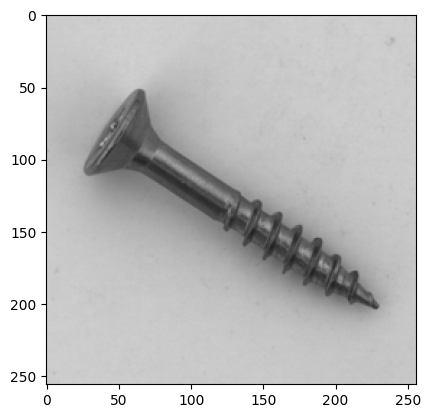

In [10]:
plt.imshow(x_val[0])
plt.show()

In [11]:
latent_dim = 1024
encoder_net = tf.keras.Sequential(
    [InputLayer(input_shape=(256, 256, 3)),
     Conv2D(64, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2D(128, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2D(256, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2D(512, 3, strides=2, padding='same', activation=tf.nn.relu)])

decoder_net = tf.keras.Sequential(
    [InputLayer(input_shape=(latent_dim,)), Dense(16 * 16 * 64), Reshape(target_shape=(16, 16, 64)),
     Conv2DTranspose(256, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2DTranspose(128, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2DTranspose(64, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2DTranspose(32, 3, strides=2, padding='same', activation=tf.nn.relu),
     Conv2DTranspose(3, 3, strides=1, padding='same', activation='sigmoid')])
od = OutlierVAE(threshold=.002, score_type='mse', encoder_net=encoder_net, decoder_net=decoder_net,latent_dim=latent_dim, )

In [12]:
# %% Training
od.fit(x_train, epochs=10000,batch_size=8,verbose=True)

32/32 [=] - 1s 46ms/step - loss_ma: -406274.6281


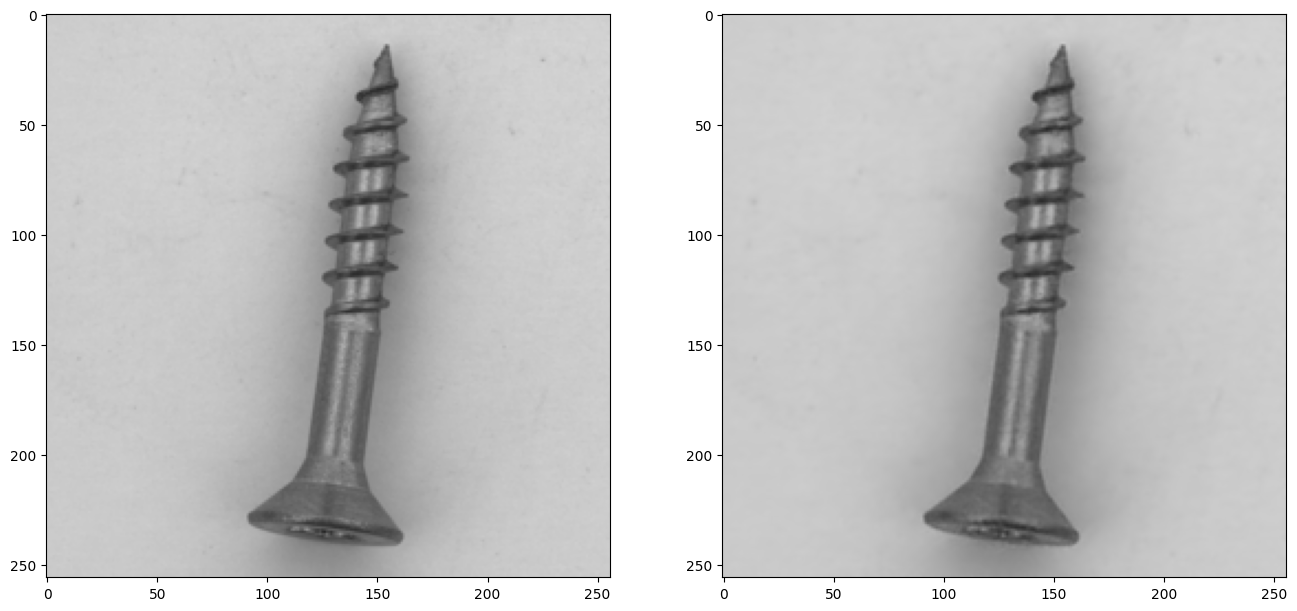

In [14]:
# %% Reconstruct Training Image
idx = 53
x = x_train[idx].reshape(1, 256, 256, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())
plt.show()

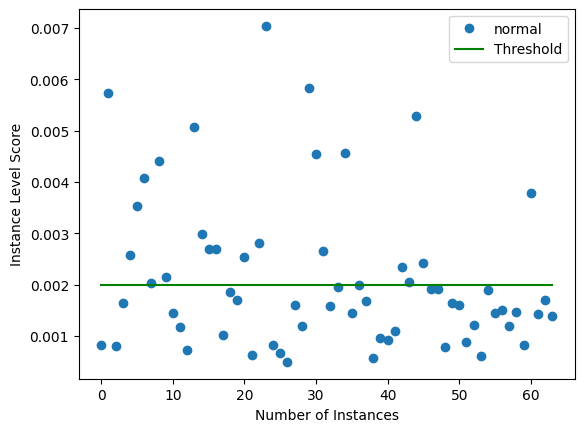

In [15]:
# %% Validation
od_preds = od.predict(x_val, outlier_type='instance', return_feature_score=True, return_instance_score=True,batch_size=8)

target = np.zeros(x_val.shape[0], ).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

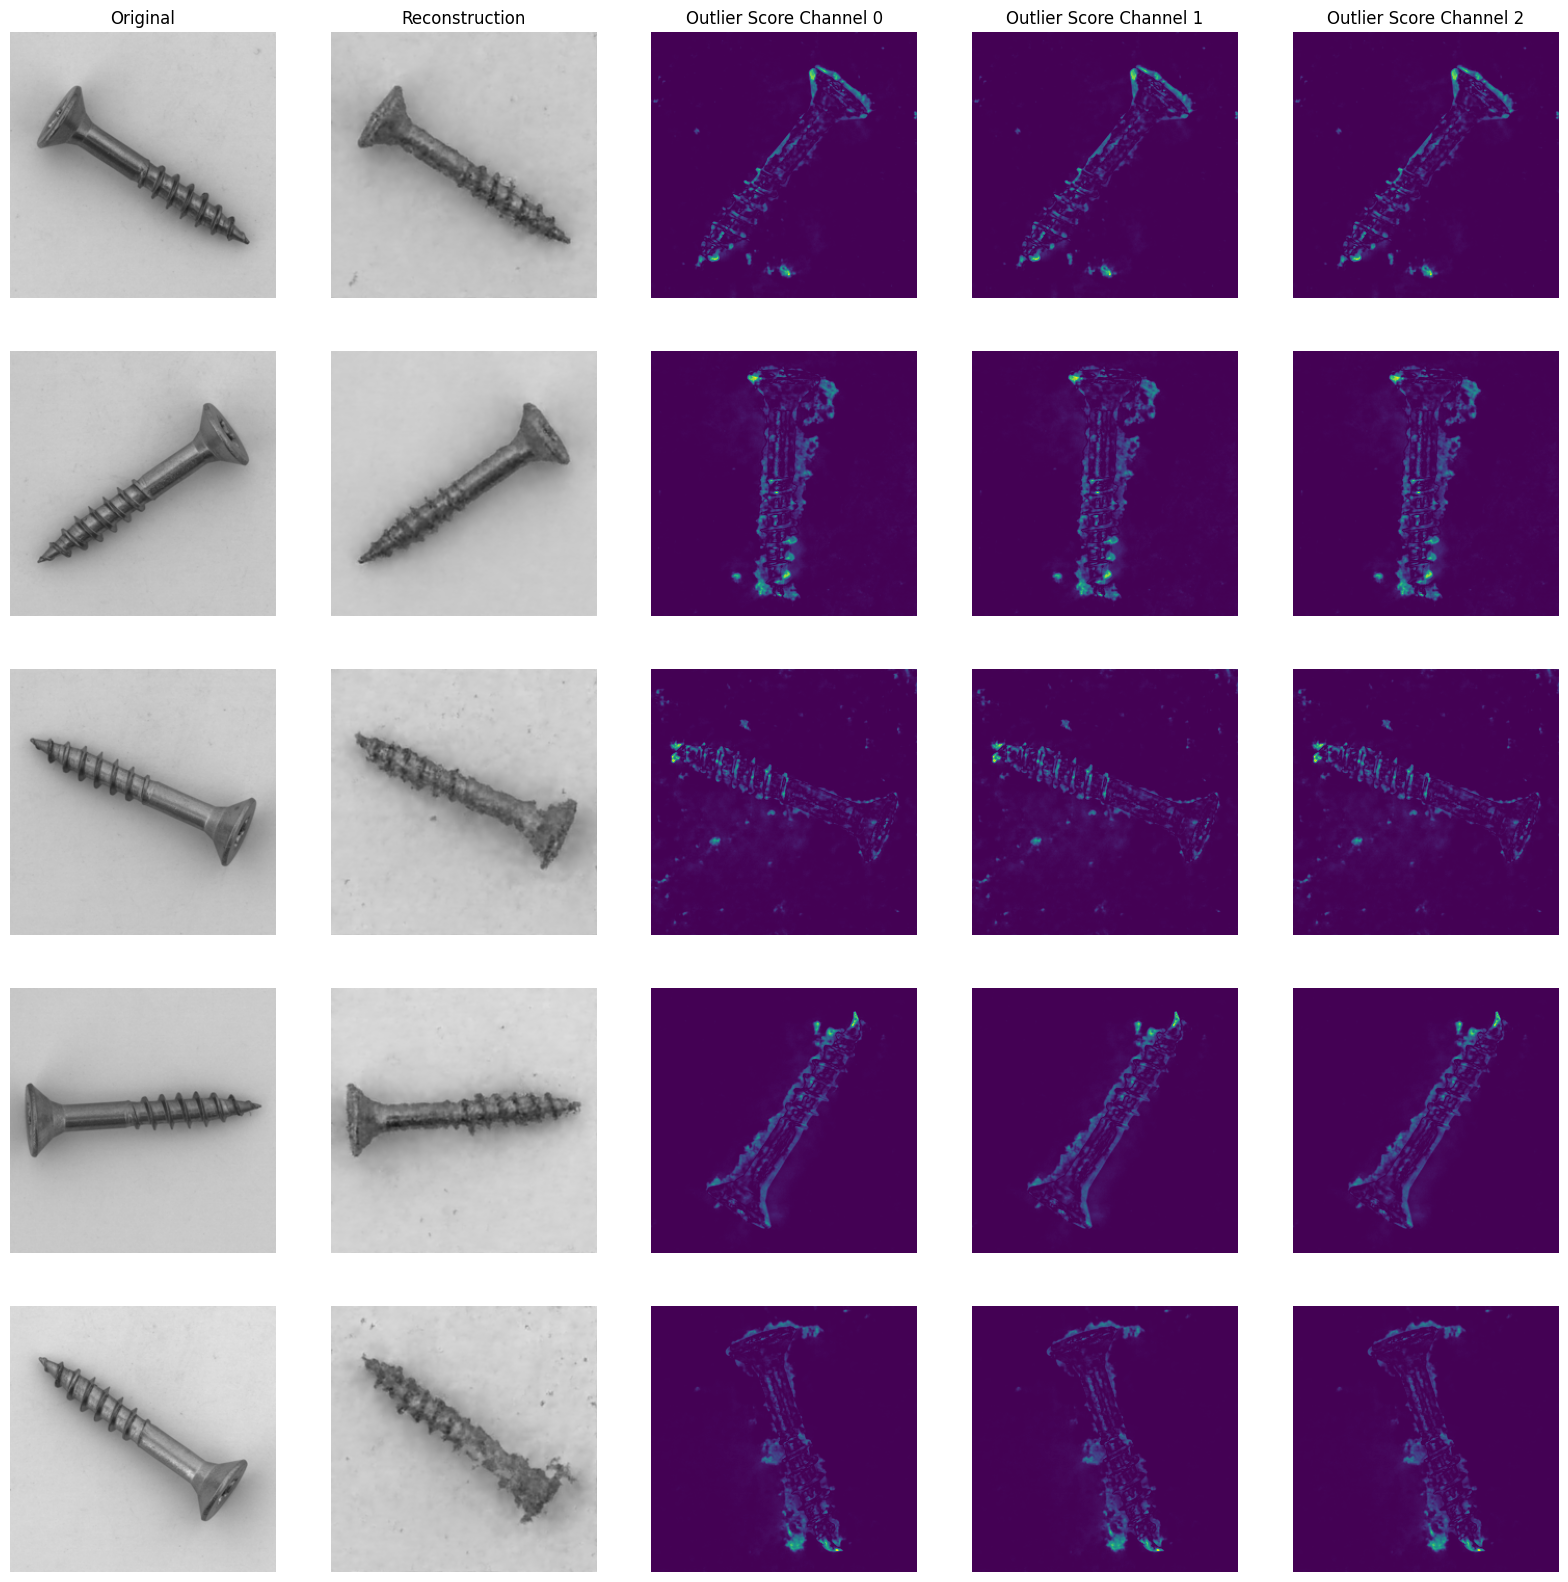

In [24]:
# %% Reconstruct Validation Images
x_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(od_preds, x_val, X_recon=x_recon, max_instances=5, outliers_only=True)

In [17]:
test_img_list = glob('C:\\Users\\LEE CHANG YOUNG\\Documents\\GitHub\\alibi-detect_test\\ng_screw\\*.png')

In [18]:

len(test_img_list)

143

In [19]:
x_test = img_to_np(test_img_list)
x_test = x_test.astype(np.float32) / 255.0

In [20]:
od_preds = od.predict(x_test, outlier_type='instance', return_feature_score=True, return_instance_score=True,batch_size=8)


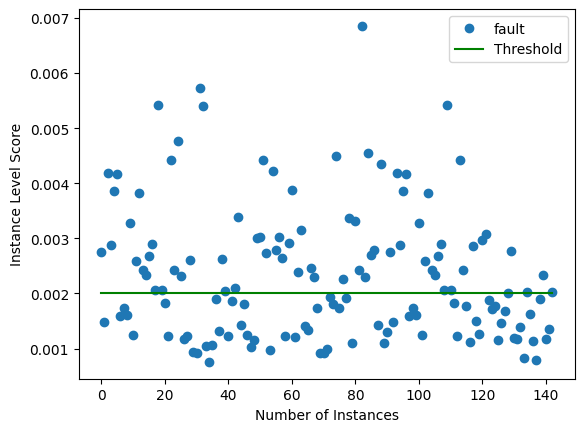

In [21]:
target = np.zeros(x_test.shape[0], ).astype(int)
labels = ['fault', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

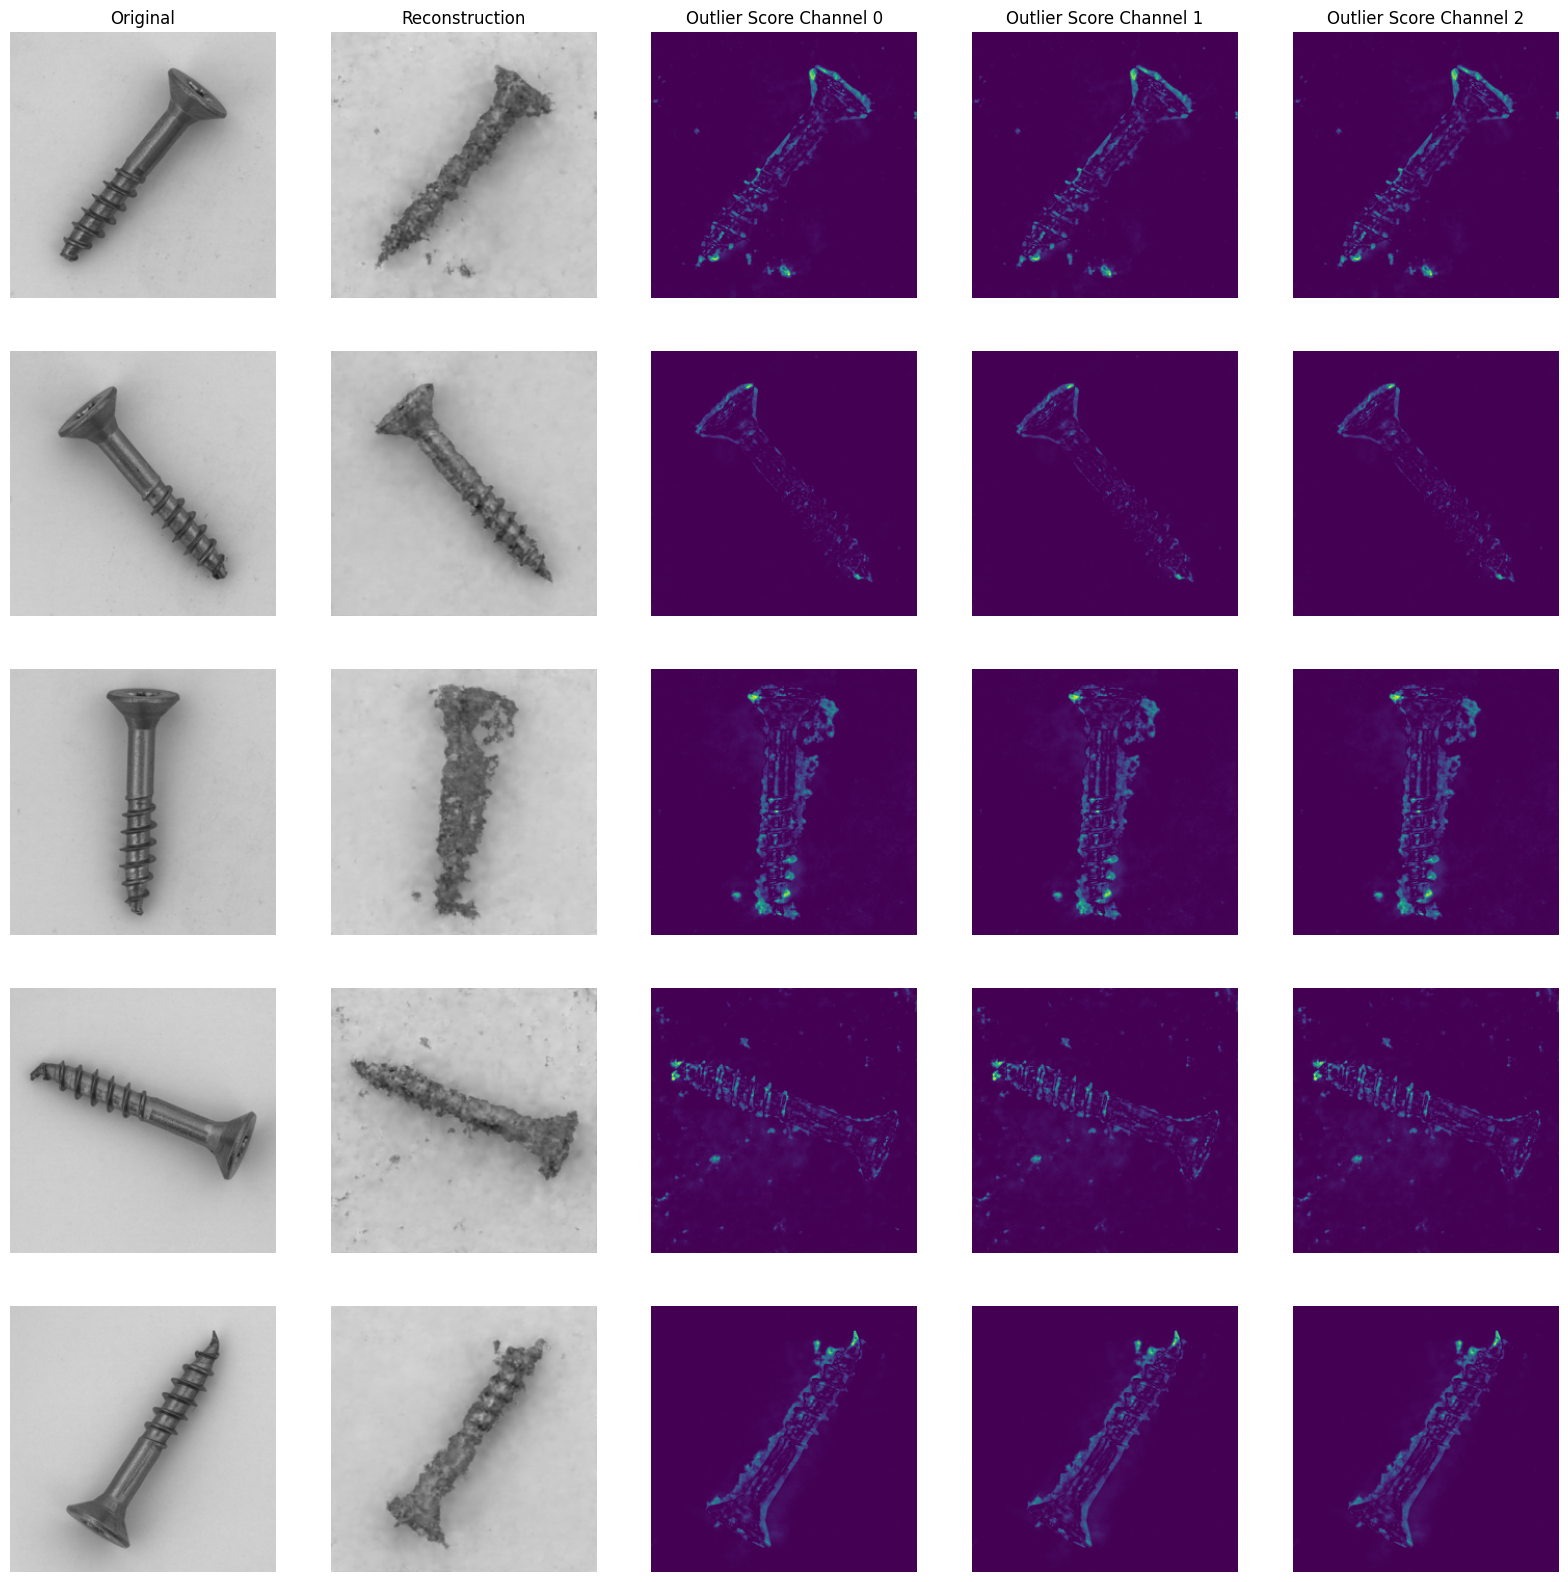

In [22]:

x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(od_preds, x_test, X_recon=x_recon, max_instances=5, outliers_only=False)

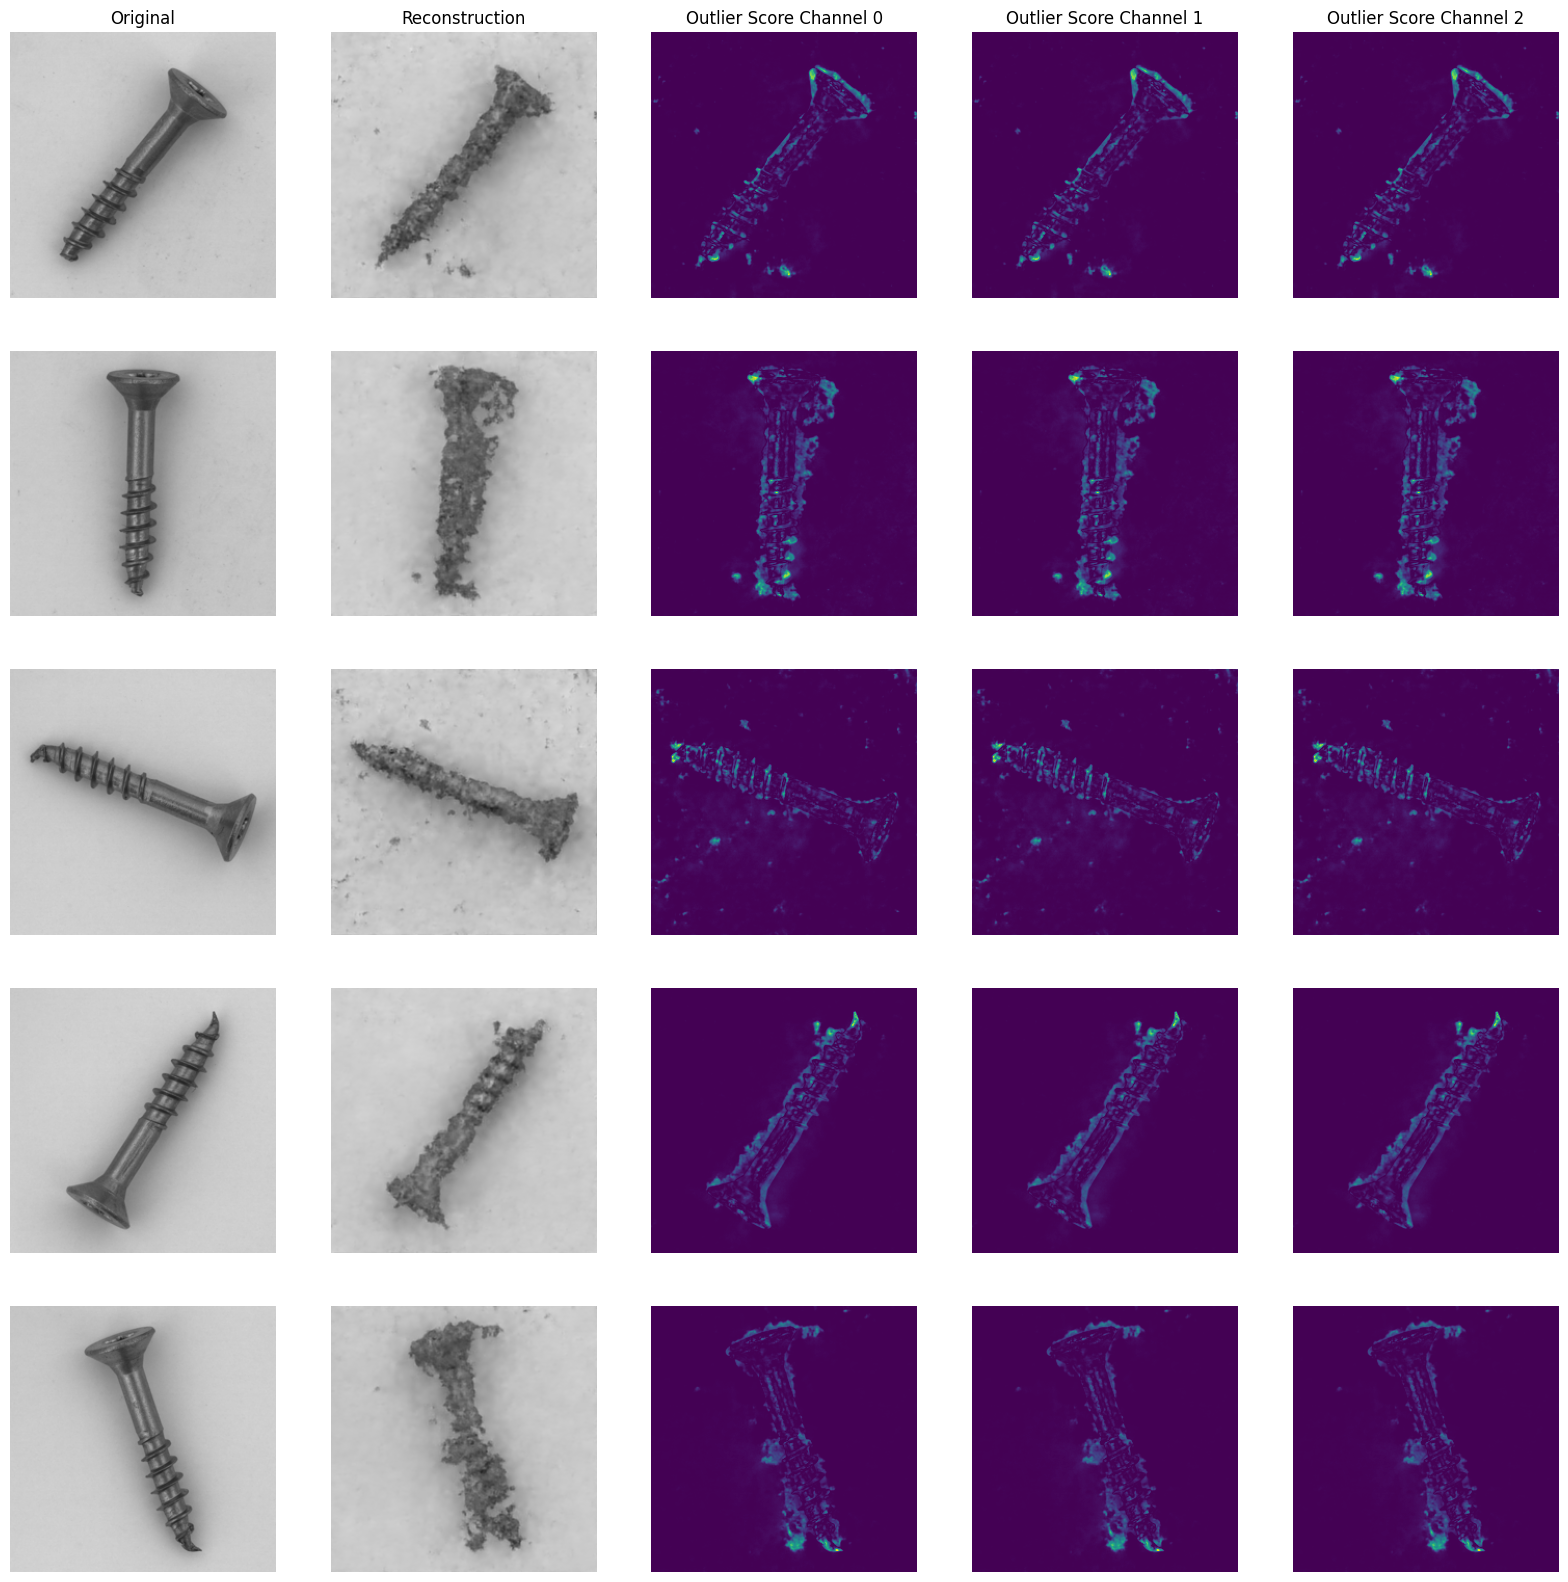

In [23]:

x_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(od_preds, x_test, X_recon=x_recon, max_instances=5, outliers_only=True)